### Recently in the United States police use of deadly force has become a politicaly important issue in conjunction with the "Black Lives Matter" movement which is concerned with the idea that systematic racism has caused the devaluing of african american lives.  In this project I will try to find insight into two questions: Are the police in the US killing a disproportionate amount of unarmed black men and where is this happening?  The Washington Post has been collecting data on police killings from 2015.  I will use this data source to answer these questions and be able to see a visual of where these have happened.

# Library Imports:

In [824]:
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.distance import vincenty

import matplotlib as mpl
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import folium # plotting library

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

print('Libraries imported.')

Libraries imported.


In [825]:
policekillings = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/CurrentPoliceKilling.csv")

In [827]:
# size of dataframe (rows, columns)
policekillings.shape

(5424, 14)

## Remove Not Used Columns

In [828]:
policekillings.drop(['id', 'name', 'manner_of_death', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera'], axis=1, inplace=True)


## Remove all incidents that are not "Unarmed"

In [829]:
policekillings.drop(policekillings.loc[policekillings['armed']!='unarmed'].index, inplace=True)

## Remove "Armed" column as its not needed.

In [830]:
policekillings.drop(['armed'], axis=1, inplace=True)

In [831]:
policekillings.shape

(352, 6)

## Create year column based on date and drop date column

In [832]:
policekillings['year'] = pd.DatetimeIndex(policekillings['date']).year
policekillings.drop(['date'], axis=1, inplace=True)
policekillings = policekillings.reset_index()

## Create location column based on city + state columns, drop city and state columns

In [833]:
policekillings["location"] = policekillings["city"].astype(str) + ', ' + policekillings["state"].astype(str)
policekillings.drop(['city', 'state'], axis=1, inplace=True)

In [834]:
policekillings.drop(['index'], axis=1, inplace=True)

## Use geolocator to obtain coordinates of each city

In [835]:
geolocator = Nominatim(country_bias='US', user_agent="us_explorer", timeout=10)
geo = policekillings['location'].unique()
d = dict(zip(geo, pd.Series(geo).apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='US') instead.
  """Entry point for launching an IPython kernel.


## Convert dictionary to Pandas Dataframe with two columns, reset index, rename index to
## "location"

In [836]:
coor = pd.DataFrame.from_dict(d, orient='index',
                       columns=['latitude', 'longitude'])
coor = coor.reset_index()
coor.columns = ['location', 'latitude', 'longitude']

In [837]:
coor.shape

(287, 3)

## Merge two Dataframes so that the original now has the coordinates of each location

In [838]:
policekillings = pd.merge(policekillings, coor, on="location", how='left')
pd.set_option('display.max_rows', None)

## Convert race letters to Words

In [839]:
pk1 = policekillings

pk1 = pk1.replace({'race':'H'}, {'race':'Hispanic'}, regex=True)
pk1 = pk1.replace({'race':'W'}, {'race':'White'}, regex=True)
pk1 = pk1.replace({'race':'B'}, {'race':'Black'}, regex=True)
pk1 = pk1.replace({'race':'O'}, {'race':'Other'}, regex=True)
pk1 = pk1.replace({'race':'A'}, {'race':'Asian'}, regex=True)
pk1 = pk1.replace({'race':'N'}, {'race':'Other'}, regex=True)
pk1['race'] = pk1['race'].fillna('Unknown')

## Get USA coordinates for Map

In [840]:
usa_address = 'USA'

geolocator = Nominatim(user_agent="us_explorer")
location = geolocator.geocode(usa_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the United States are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the United States are 39.7837304, -100.4458825.


# Map of the USA showing Police Killings of Unarmed Individuals
## Marker Color Indicates Race
### White = Caucasian
### Black = African American
### Tan = Brown
### Yellow = Asian
### Blue= Other

In [841]:
pk2 = pk1.groupby('race')['location'].count()
pk2 = pd.DataFrame(pk2)
pk2 = pk2.reset_index()
pk2.columns = ['race', 'unarmed deaths']

Asian = pk2.loc[0].at['unarmed deaths']
Black= pk2.loc[1].at['unarmed deaths']
Hispanic= pk2.loc[2].at['unarmed deaths']
Other= pk2.loc[3].at['unarmed deaths']
Unknown= pk2.loc[4].at['unarmed deaths']
White= pk2.loc[5].at['unarmed deaths']

print("Between 2015 and 2020, the police in America killed the following unarmed persons:"'\n'
      'Asian', Asian,'\n'
      'African American', Black,'\n'
      'Hispanic', Hispanic,'\n'
      'Other', Other,'\n'
      'Unknown', Unknown,'\n'
      'Caucasian', White,'\n')

print('White = Caucasian''\n'
'Black = African American''\n'
'Tan = Brown''\n'
'Yellow = Asian''\n'
'Blue= Other''\n')

# create map of USA using latitude and longitude values
map_usa = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, loc, race, age, gender, year in zip(pk1['latitude'], pk1['longitude'], pk1['location'], pk1['race'], pk1['age'], pk1['gender'], pk1['year']):
    if race == 'Black':   
        label = 'Age {}, Gender {}, Year {}, Location {}'.format(age, gender, year, loc)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
    elif race == 'White':
         label = 'Age {}, Gender {}, Year {}, Location {}'.format(age, gender, year, loc)
         label = folium.Popup(label, parse_html=True)
         folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='black',
            fill=True,
            fill_color='white',
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
    elif race == 'Hispanic':
         label = 'Age {}, Gender {}, Year {}, Location {}'.format(age, gender, year, loc)
         label = folium.Popup(label, parse_html=True)
         folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='brown',
            fill=True,
            fill_color='brown',
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
    elif race == 'Asian':
         label = 'Age {}, Gender {}, Year {}, Location {}'.format(age, gender, year, loc)
         label = folium.Popup(label, parse_html=True)
         folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
    elif race == 'Other' or 'Unknown':
         label = 'Age {}, Gender {}, Year {}, Location {}'.format(age, gender, year, loc)
         label = folium.Popup(label, parse_html=True)
         folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
            parse_html=False).add_to(map_usa)
    
map_usa

Between 2015 and 2020, the police in America killed the following unarmed persons:
Asian 7 
African American 123 
Hispanic 63 
Other 9 
Unknown 5 
Caucasian 145 

White = Caucasian
Black = African American
Tan = Brown
Yellow = Asian
Blue= Other



### This map indicates a geographic locations of police unarmed shootings.  African American incidents tend to be on the eastern portion of the country with a few incidents in California and Washington state.  Caucasian incidents tend to be more spread over the country.  Hispanic tend to be in the south western portion of country.  Asian incidents tend to be on the western seaboard.

# Import Estimated USA Population Data from 2015 to 2020
## Merge Population Data with Refactored Unarmed Deaths Based on Race
### Calculate Deaths Per 10 Million and Compare by Race

In [842]:
popdata = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/Us_Census_Pop_By_Race_df.csv")
pk5 = pk1.groupby(['year','race'])['race'].size()
pk5 = pd.DataFrame(data=pk5)
pk5.index.name = 'year'
pk5.columns.values[0] = 'unarmed deaths'
pk5 = pk5.reset_index()
pk5 = pk5.replace(['Unknown'], 'Other')
pk5 = pk5.groupby(['year', 'race'])['unarmed deaths'].sum()
pk5 = pd.DataFrame(data=pk5)
pk5 = pk5.reset_index()
pk6 = pd.merge(pk5, popdata, on=['year', 'race'])
pk6 = pk6.set_index(['year', 'race'])
pk6['Killed Per 10 Million'] = ((pk6['unarmed deaths'] / pk6['est pop']) * 10000000)#.astype('int64')
pk6 = pk6.round(decimals=2)
pk6 = pk6.reset_index()

# Extract rate per race and then merge into new dataframe:

In [843]:
pkblk = pk6[pk6['race']  == 'Black']
pkblk = pd.DataFrame(pkblk)
pkblk.drop(['race', 'unarmed deaths', 'est pop'], axis=1, inplace=True)
pkblk.rename(columns = {'Killed Per 10 Million':'Black'}, inplace = True)

pkwht = pk6[pk6['race']  == 'White']
pkwht = pd.DataFrame(pkwht)
pkwht.drop(['race', 'unarmed deaths', 'est pop'], axis=1, inplace=True)
pkwht.rename(columns = {'Killed Per 10 Million':'White'}, inplace = True)

pkhs = pk6[pk6['race']  == 'Hispanic']
pkhs = pd.DataFrame(pkhs)
pkhs.drop(['race', 'unarmed deaths', 'est pop'], axis=1, inplace=True)
pkhs.rename(columns = {'Killed Per 10 Million':'Hispanic'}, inplace = True)

pkot = pk6[pk6['race']  == 'Other']
pkot = pd.DataFrame(pkot)
pkot.drop(['race', 'unarmed deaths', 'est pop'], axis=1, inplace=True)
pkot.rename(columns = {'Killed Per 10 Million':'Other'}, inplace = True)

pkas = pk6[pk6['race']  == 'Asian']
pkas = pd.DataFrame(pkas)
pkas.drop(['race', 'unarmed deaths', 'est pop'], axis=1, inplace=True)
pkas.rename(columns = {'Killed Per 10 Million':'Asian'}, inplace = True)
yr_2015 = {'year':2015, 'Asian':0}
pkas = pkas.append(yr_2015, ignore_index=True)
yr_2016 = {'year':2016, 'Asian':0}
pkas = pkas.append(yr_2016, ignore_index=True)
pk7 = pd.merge(pkblk, pkwht, on='year')
pk7 = pd.merge(pk7, pkhs, on='year')
pk7 = pd.merge(pk7, pkot, on='year')
pk7 = pd.merge(pk7, pkas, on='year')
pk7.head()

,year,Black,White,Hispanic,Other,Asian
0,2015,8.91,1.62,3.79,3.84,0.00
1,2016,4.42,1.11,1.76,0.75,0.00
2,2017,5.06,1.57,2.49,2.20,0.53
3,2018,5.25,1.27,1.50,0.72,0.52
4,2019,3.16,1.26,2.11,0.71,2.03


# Create Line Plot Showing "Killed Per 10 Million" For Each Ethnic Group
## Customize Lineplot

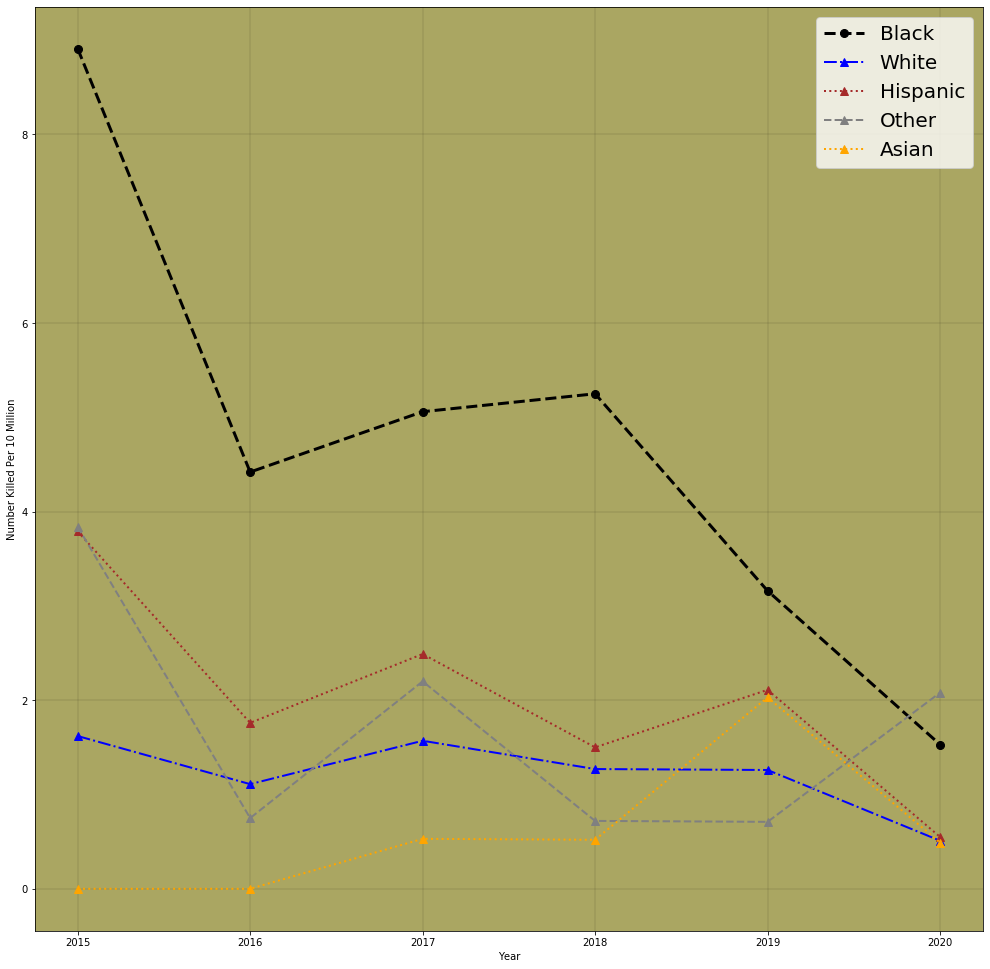

In [871]:
plt.rc('legend',fontsize=20)
#plt.rc('legend',fontsize='x-large')

plt.figure(figsize=(17,17))
ax = plt.gca()
ax.set_facecolor('xkcd:khaki')

pk7.plot(kind='line',x='year',y='Black', color='black', ax=ax, linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='black', markersize=8)
pk7.plot(kind='line',x='year',y='White', color='blue', ax=ax, linestyle='dashdot', linewidth = 2, 
         marker='^', markerfacecolor='blue', markersize=8)
pk7.plot(kind='line',x='year',y='Hispanic', color='brown', ax=ax, linestyle='dotted', linewidth = 2, 
         marker='^', markerfacecolor='brown', markersize=8)
pk7.plot(kind='line',x='year',y='Other', color='gray', ax=ax, linestyle='--', linewidth = 2, 
         marker='^', markerfacecolor='gray', markersize=8)
pk7.plot(kind='line',x='year',y='Asian', color='orange', ax=ax, linestyle='dotted', linewidth = 2, 
         marker='^', markerfacecolor='orange', markersize=8)

plt.xlabel('Year')
plt.ylabel('Number Killed Per 10 Million')

  #adds major gridlines
ax.grid(color='black', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

### The line graph above depicts unarmed deaths by police by ethnicity and number killed per 10 million.  The rate of African American's killed in 2015 was much higher than any other ethnicity, although it does decrease over time.  The other ethnicities stay consistent, but this graph indicates that there are more deaths of african americans than any other ethnicity per number of people in the country.  
#### Note: 2020 is a partial year so it's numbers are lower than other years.

# Import estimated population data by race and year
## Merge population data with unarmed police shooting by race and year

In [845]:
popdata = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/Us_Census_Pop_By_Race_df.csv")
pk8 = pk1.groupby(['year','race'])['race'].size()
pk8 = pd.DataFrame(data=pk8)
pk8.columns.values[0] = 'unarmed deaths'
pk8 = pk8.reset_index()
pk8 = pk8.replace(['Unknown'], 'Other')
pk8 = pk8.groupby(['year', 'race'])['unarmed deaths'].sum()
pk8 = pd.DataFrame(data=pk8)
pk8 = pk8.reset_index()
pk9 = pd.merge(pk8, popdata, on=['year', 'race'])
pk9 = pk9.set_index(['year', 'race'])
pk9 = pk9.reset_index()
indexNames = pk9[(pk9['year'] >= 2019) & (pk9['year'] <= 2020)].index
pk9.drop(indexNames, inplace=True)

# Import violent crime data sets by race
## Rename columns, combine "White" and "Hispanic"
### Concatenate into one dataframe

In [846]:
rc2015 = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/offender-race-2015.csv")
rc2015_df = pd.DataFrame(data=rc2015)
rc2015_df.rename(columns = {'Key':'race', 'Value':'violent crimes'}, inplace = True)
rc2015_df = rc2015_df.drop(rc2015_df.index[1])
rc2015_df = rc2015_df.reset_index()
new_row = pd.Series(data={'index':7, 'race':'Other', 'violent crimes':(rc2015_df.at[2, 'violent crimes']) + (rc2015_df.at[4, 'violent crimes'])}, name='6')
rc2015_df = rc2015_df.append(new_row, ignore_index=False)
rc2015_df = rc2015_df.drop([2, 4], axis=0)
rc2015_df = rc2015_df.reset_index()
rc2015_df.insert(1, "year", [2015, 2015, 2015, 2015], True)
rc2015_df = rc2015_df.drop(['level_0', 'index'], axis=1)
rc2015_df = rc2015_df.replace(['Black or African American'], 'Black')
rc2015_df = rc2015_df.replace(['White'], 'White and Hispanic')

rc2016 = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/offender-race-2016.csv")
rc2016_df = pd.DataFrame(data=rc2016)
rc2016_df.rename(columns = {'Key':'race', 'Value':'violent crimes'}, inplace = True)
rc2016_df = rc2016_df.drop(rc2016_df.index[1])
rc2016_df = rc2016_df.reset_index()
new_row = pd.Series(data={'index':7, 'race':'Other', 'violent crimes':(rc2016_df.at[2, 'violent crimes']) + (rc2016_df.at[4, 'violent crimes'])}, name='6')
rc2016_df = rc2016_df.append(new_row, ignore_index=False)
rc2016_df = rc2016_df.drop([2, 4], axis=0)
rc2016_df = rc2016_df.reset_index()
rc2016_df.insert(1, "year", [2016, 2016, 2016, 2016], True)
rc2016_df = rc2016_df.drop(['level_0', 'index'], axis=1)
rc2016_df = rc2016_df.replace(['Black or African American'], 'Black')
rc2016_df = rc2016_df.replace(['White'], 'White and Hispanic')

rc2017 = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/offender-race-2017.csv")
rc2017_df = pd.DataFrame(data=rc2017)
rc2017_df.rename(columns = {'Key':'race', 'Value':'violent crimes'}, inplace = True)
rc2017_df = rc2017_df.drop(rc2017_df.index[1])
rc2017_df = rc2017_df.reset_index()
new_row = pd.Series(data={'index':7, 'race':'Other', 'violent crimes':(rc2017_df.at[2, 'violent crimes']) + (rc2017_df.at[4, 'violent crimes'])}, name='6')
rc2017_df = rc2017_df.append(new_row, ignore_index=False)
rc2017_df = rc2017_df.drop([2, 4], axis=0)
rc2017_df = rc2017_df.reset_index()
rc2017_df.insert(1, "year", [2017, 2017, 2017, 2017], True)
rc2017_df = rc2017_df.drop(['level_0', 'index'], axis=1)
rc2017_df = rc2017_df.replace(['Black or African American'], 'Black')
rc2017_df = rc2017_df.replace(['White'], 'White and Hispanic')

rc2018 = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/offender-race-2018.csv")
rc2018_df = pd.DataFrame(data=rc2018)
rc2018_df.rename(columns = {'Key':'race', 'Value':'violent crimes'}, inplace = True)
rc2018_df = rc2018_df.drop(rc2018_df.index[1])
rc2018_df = rc2018_df.reset_index()
new_row = pd.Series(data={'index':7, 'race':'Other', 'violent crimes':(rc2018_df.at[2, 'violent crimes']) + (rc2018_df.at[4, 'violent crimes'])}, name='6')
rc2018_df = rc2018_df.append(new_row, ignore_index=False)
rc2018_df = rc2018_df.drop([2, 4], axis=0)
rc2018_df = rc2018_df.reset_index()
rc2018_df.insert(1, "year", [2018, 2018, 2018, 2018], True)
rc2018_df = rc2018_df.drop(['level_0', 'index'], axis=1)
rc2018_df = rc2018_df.replace(['Black or African American'], 'Black')
rc2018_df = rc2018_df.replace(['White'], 'White and Hispanic')

frames = [rc2015_df, rc2016_df, rc2017_df, rc2018_df]
rc_off_df = pd.concat(frames)

# Combine "White" and "Hispanic" data in PK9 dataframe
## Remove rows for "White" and "Hispanic"
### Add in "Asian" population data from popdata dataframe
### Merge Violent Crime and Unarmed Deaths By Race dataframes
### Add in "Killed Per 10 Million" Column

In [847]:
new_row = pd.Series(data={'year':2015, 'race':'White and Hispanic', 'unarmed deaths':(pk9.at[1, 'unarmed deaths']) + (pk9.at[3, 'unarmed deaths']), 'est pop':(pk9.at[1, 'est pop']) + (pk9.at[3, 'est pop'])}, name='18')
pk9 = pk9.append(new_row, ignore_index=False)
pk9 = pk9.drop([1, 3], axis=0)

new_row = pd.Series(data={'year':2016, 'race':'White and Hispanic', 'unarmed deaths':(pk9.at[5, 'unarmed deaths']) + (pk9.at[7, 'unarmed deaths']), 'est pop':(pk9.at[5, 'est pop']) + (pk9.at[7, 'est pop'])}, name='19')
pk9 = pk9.append(new_row, ignore_index=False)
pk9 = pk9.drop([5, 7], axis=0)

new_row = pd.Series(data={'year':2017, 'race':'White and Hispanic', 'unarmed deaths':(pk9.at[10, 'unarmed deaths']) + (pk9.at[12, 'unarmed deaths']), 'est pop':(pk9.at[10, 'est pop']) + (pk9.at[12, 'est pop'])}, name='20')
pk9 = pk9.append(new_row, ignore_index=False)
pk9 = pk9.drop([10, 12], axis=0)

new_row = pd.Series(data={'year':2018, 'race':'White and Hispanic', 'unarmed deaths':(pk9.at[15, 'unarmed deaths']) + (pk9.at[17, 'unarmed deaths']), 'est pop':(pk9.at[15, 'est pop']) + (pk9.at[17, 'est pop'])}, name='21')
pk9 = pk9.append(new_row, ignore_index=False)
pk9 = pk9.drop([15, 17], axis=0)

new_row = pd.Series(data={'year':2015, 'race':'Asian', 'unarmed deaths':0, 'est pop':(popdata.at[3, 'est pop'])}, name='22')
pk9 = pk9.append(new_row, ignore_index=False)

new_row = pd.Series(data={'year':2016, 'race':'Asian', 'unarmed deaths':0, 'est pop':(popdata.at[8, 'est pop'])}, name='23')
pk9 = pk9.append(new_row, ignore_index=False)

pk9 = pk9.reset_index()

pk9 = pk9.sort_values(by='year', ascending=True)
pk9 = pk9.drop(['index'], axis=1)

pk10 = pd.merge(pk9, rc_off_df, on=['year', 'race'])

pk10['Killed Per 10 Million'] = ((pk10['unarmed deaths'] / pk10['est pop']) * 10000000)#.astype('int64')
pk10 = pk10.round(decimals=2)
pk10 = pk10.sort_values(['year', 'race'])

# Calculate percentage of total crime per race
## Merge data with dataframe

In [848]:
result = []

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):
    if yr == 2015 and rc == 'Asian':   
        count0 = vc 
    if yr == 2015 and rc == 'Black':   
        count1 = vc
    if yr == 2015 and rc == 'Other':   
        count2 = vc
    if yr == 2015 and rc == 'White and Hispanic':   
        count3 = vc
total = (count0 + count1 + count2 + count3)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):
    if yr == 2015 and rc == 'Asian':
        per0 = ((count0 / total) * 100)
        result.append(per0)
    
    if yr == 2015 and rc == 'Black':
        per0 = ((count1 / total) * 100)
        result.append(per0)
        
    if yr == 2015 and rc == 'Other':
        per0 = ((count2 / total) * 100)
        result.append(per0)
        
    if yr == 2015 and rc == 'White and Hispanic':
        per0 = ((count3 / total) * 100)
        result.append(per0)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):        
    if yr == 2016 and rc == 'Asian':   
        count0 = vc 
    if yr == 2016 and rc == 'Black':   
        count1 = vc
    if yr == 2016 and rc == 'Other':   
        count2 = vc
    if yr == 2016 and rc == 'White and Hispanic':   
        count3 = vc
        
total = (count0 + count1 + count2 + count3)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):
    if yr == 2016 and rc == 'Asian':
        per1 = ((count0 / total) * 100)
        result.append(per1)
        
    if yr == 2016 and rc == 'Black':
        per1 = ((count1 / total) * 100)
        result.append(per1)
        
    if yr == 2016 and rc == 'Other':
        per1 = ((count2 / total) * 100)
        result.append(per1)
        
    if yr == 2016 and rc == 'White and Hispanic':
        per1 = ((count3 / total) * 100)
        result.append(per1)
        
for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):        
    if yr == 2017 and rc == 'Asian':   
        count0 = vc 
    if yr == 2017 and rc == 'Black':   
        count1 = vc
    if yr == 2017 and rc == 'Other':   
        count2 = vc
    if yr == 2017 and rc == 'White and Hispanic':   
        count3 = vc
        
total = (count0 + count1 + count2 + count3)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):
    if yr == 2017 and rc == 'Asian':
        per2 = ((count0 / total) * 100)
        result.append(per2)
        
    if yr == 2017 and rc == 'Black':
        per2 = ((count1 / total) * 100)
        result.append(per2)
        
    if yr == 2017 and rc == 'Other':
        per2 = ((count2 / total) * 100)
        result.append(per2)
        
    if yr == 2017 and rc == 'White and Hispanic':
        per2 = ((count3 / total) * 100)
        result.append(per2)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):        
    if yr == 2018 and rc == 'Asian':   
        count0 = vc 
    if yr == 2018 and rc == 'Black':   
        count1 = vc
    if yr == 2018 and rc == 'Other':   
        count2 = vc
    if yr == 2018 and rc == 'White and Hispanic':   
        count3 = vc
        
total = (count0 + count1 + count2 + count3)

for yr, rc, vc in zip(pk10['year'], pk10['race'], pk10['violent crimes']):
    if yr == 2018 and rc == 'Asian':
        per3 = ((count0 / total) * 100)
        result.append(per3)
        
    if yr == 2018 and rc == 'Black':
        per3 = ((count1 / total) * 100)
        result.append(per3)
        
    if yr == 2018 and rc == 'Other':
        per3 = ((count2 / total) * 100)
        result.append(per3)
        
    if yr == 2018 and rc == 'White and Hispanic':
        per3 = ((count3 / total) * 100)
        result.append(per3)
  
pk10['% violent crime'] = result
pk10 = pk10.round(decimals=2)
pk10 = pk10.reset_index()
pk10 = pk10.drop(['index'], axis=1)

In [849]:
result = []

for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2015 and rc == 'Asian':   
        count0 = ep 
    if yr == 2015 and rc == 'Black':   
        count1 = ep
    if yr == 2015 and rc == 'Other':   
        count2 = ep
    if yr == 2015 and rc == 'White and Hispanic':   
        count3 = ep
total = (count0 + count1 + count2 + count3)

for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2015 and rc == 'Asian':
        per0 = ((ep / total) * 100)
        result.append(per0)
    
    if yr == 2015 and rc == 'Black':
        per0 = ((ep / total) * 100)
        result.append(per0)
        
    if yr == 2015 and rc == 'Other':
        per0 = ((ep / total) * 100)
        result.append(per0)
        
    if yr == 2015 and rc == 'White and Hispanic':
        per0 = ((ep / total) * 100)
        result.append(per0)
        
for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2016 and rc == 'Asian':   
        count0 = ep 
    if yr == 2016 and rc == 'Black':   
        count1 = ep
    if yr == 2016 and rc == 'Other':   
        count2 = ep
    if yr == 2016 and rc == 'White and Hispanic':   
        count3 = ep
total = (count0 + count1 + count2 + count3)

for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2016 and rc == 'Asian':
        per1 = ((ep / total) * 100)
        result.append(per1)
    
    if yr == 2016 and rc == 'Black':
        per1 = ((ep / total) * 100)
        result.append(per1)
        
    if yr == 2016 and rc == 'Other':
        per1 = ((ep / total) * 100)
        result.append(per1)
        
    if yr == 2016 and rc == 'White and Hispanic':
        per1 = ((ep / total) * 100)
        result.append(per1)
        
for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2017 and rc == 'Asian':   
        count0 = ep 
    if yr == 2017 and rc == 'Black':   
        count1 = ep
    if yr == 2017 and rc == 'Other':   
        count2 = ep
    if yr == 2017 and rc == 'White and Hispanic':   
        count3 = ep
total = (count0 + count1 + count2 + count3)

for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2017 and rc == 'Asian':
        per2 = ((ep / total) * 100)
        result.append(per2)
    
    if yr == 2017 and rc == 'Black':
        per2 = ((ep / total) * 100)
        result.append(per2)
        
    if yr == 2017 and rc == 'Other':
        per2 = ((ep / total) * 100)
        result.append(per2)
        
    if yr == 2017 and rc == 'White and Hispanic':
        per2 = ((ep / total) * 100)
        result.append(per2)
        
for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2018 and rc == 'Asian':   
        count0 = ep 
    if yr == 2018 and rc == 'Black':   
        count1 = ep
    if yr == 2018 and rc == 'Other':   
        count2 = ep
    if yr == 2018 and rc == 'White and Hispanic':   
        count3 = ep
total = (count0 + count1 + count2 + count3)

for yr, rc, ep in zip(pk10['year'], pk10['race'], pk10['est pop']):
    if yr == 2018 and rc == 'Asian':
        per3 = ((ep / total) * 100)
        result.append(per3)
    
    if yr == 2018 and rc == 'Black':
        per3 = ((ep / total) * 100)
        result.append(per3)
        
    if yr == 2018 and rc == 'Other':
        per3 = ((ep / total) * 100)
        result.append(per3)
        
    if yr == 2018 and rc == 'White and Hispanic':
        per3 = ((ep / total) * 100)
        result.append(per3)

pk10['% population'] = result
pk10 = pk10.round(decimals=2)
pk10 = pk10.reset_index()
pk10 = pk10.drop(['index'], axis=1)

In [850]:
# get the data
pk11 = pk10.copy()
pk11 = pk11.drop(['unarmed deaths', 'est pop', 'violent crimes'], axis=1)
pk2015 = pk11.loc[pk11['year'] == 2015]
pk2016 = pk11.loc[pk11['year'] == 2016]
pk2017 = pk11.loc[pk11['year'] == 2017]
pk2018 = pk11.loc[pk11['year'] == 2018]

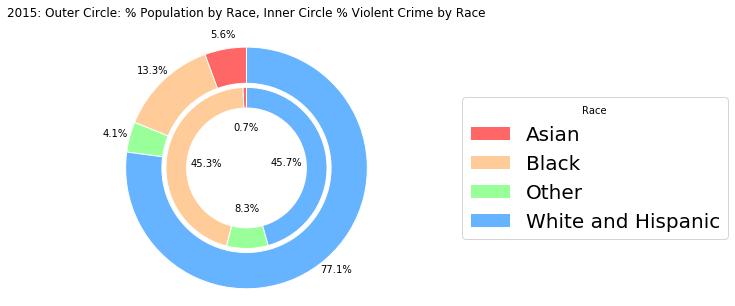

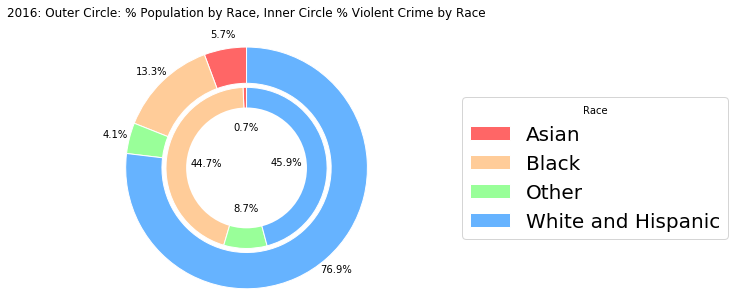

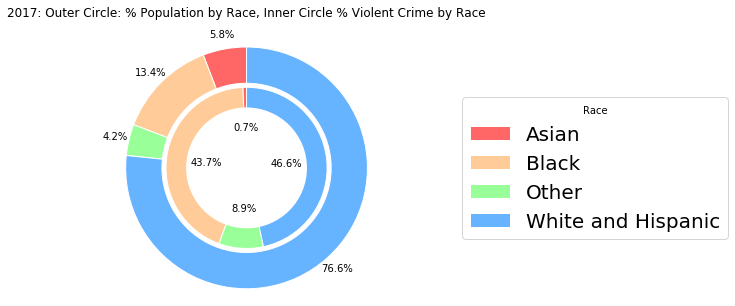

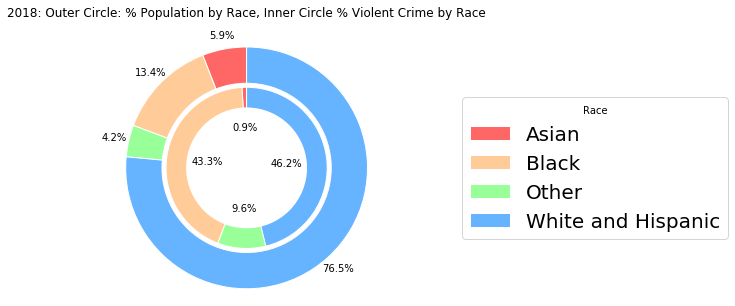

In [851]:
# Data to plot
labels = pk2015['race']
pop = pk2015['% population']
labels_crime = pk2015['race']
crime = pk2015['% violent crime']
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
colors_crime = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']

size=.9
#Plot
plt.pie(pop, autopct='%1.1f%%', pctdistance=1.12, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, frame=True, radius=3)
plt.pie(crime, autopct='%1.1f%%', pctdistance=0.5, colors=colors_crime, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()

plt.legend( labels,
          title="Race",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))



plt.title("2015: Outer Circle: % Population by Race, Inner Circle % Violent Crime by Race"'\n')
plt.show()

labels = pk2016['race']
pop = pk2016['% population']
labels_crime = pk2016['race']
crime = pk2016['% violent crime']
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
colors_crime = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']

size=.9
#Plot
plt.pie(pop, autopct='%1.1f%%', pctdistance=1.12, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, frame=True, radius=3)
plt.pie(crime, autopct='%1.1f%%', pctdistance=0.5, colors=colors_crime, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()

plt.legend( labels,
          title="Race",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))



plt.title("2016: Outer Circle: % Population by Race, Inner Circle % Violent Crime by Race"'\n')
plt.show()

labels = pk2017['race']
pop = pk2017['% population']
labels_crime = pk2017['race']
crime = pk2017['% violent crime']
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
colors_crime = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']

size=.9
#Plot
plt.pie(pop, autopct='%1.1f%%', pctdistance=1.12, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, frame=True, radius=3)
plt.pie(crime, autopct='%1.1f%%', pctdistance=0.5, colors=colors_crime, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()

plt.legend( labels,
          title="Race",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))



plt.title("2017: Outer Circle: % Population by Race, Inner Circle % Violent Crime by Race"'\n')
plt.show()

labels = pk2018['race']
pop = pk2018['% population']
labels_crime = pk2018['race']
crime = pk2018['% violent crime']
colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']
colors_crime = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff']

size=.9
#Plot
plt.pie(pop, autopct='%1.1f%%', pctdistance=1.12, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, frame=True, radius=3)
plt.pie(crime, autopct='%1.1f%%', pctdistance=0.5, colors=colors_crime, wedgeprops=dict(width=size, edgecolor='w'), startangle=90, radius=2 )
#Draw circle
centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')
plt.tight_layout()

plt.legend( labels,
          title="Race",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))



plt.title("2018: Outer Circle: % Population by Race, Inner Circle % Violent Crime by Race"'\n')
plt.show()

# Year over year analysis shows that the African American population in the United States has a disproportionate amount of violent crimes compared to other races.  This most likely plays a factor in the amount of police shootings of African Americans.

# Now that the unarmed killings by police have been analyzed, its time to look at the over all police shooting data set and compare to a few sociological factors.

In [852]:
#Import Data

policekillings = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/CurrentPoliceKilling.csv")
cityedu = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/PercentOver25CompletedHighSchool.csv")
citypoverty = pd.read_csv("/Users/sn3kyjed/Desktop/Github/Projects/DS-Capstone_Project/FinalProject/Data/PercentagePeopleBelowPovertyLevel.csv")

citypovedu =pd.merge(cityedu, citypoverty, on=['State', 'City'])
citypovedu.rename(columns = {'State':'state'}, inplace = True)
citypovedu.rename(columns = {'City':'city'}, inplace = True)

df =pd.merge(citypovedu, policekillings, how='inner', on=['city', 'state'])

# Remove columns that aren't going to be used

In [853]:
df.drop(['id', 'name', 'date', 'state', 'city', 'manner_of_death', 'body_camera', 'flee', 'armed', 'threat_level', 'signs_of_mental_illness'], axis=1, inplace=True)

# Correct Types if needed

In [854]:
print(df.dtypes)

percent_completed_hs     object
poverty_rate             object
age                     float64
gender                   object
race                     object
dtype: object


In [855]:
df[["percent_completed_hs", "poverty_rate"]] = df[["percent_completed_hs", "poverty_rate"]].astype("float")

In [856]:
print(df.dtypes)

percent_completed_hs    float64
poverty_rate            float64
age                     float64
gender                   object
race                     object
dtype: object


# Data Normalization

In [857]:
df['percent_completed_hs'] = df['percent_completed_hs']/df['percent_completed_hs'].max()
df['poverty_rate'] = df['poverty_rate']/df['poverty_rate'].max()
df['poverty_rate'] = df['poverty_rate']/df['poverty_rate'].max()
df['age'] = df['age']/df['age'].max()

In [858]:
df = df.replace(['M', 'F'], [1, 0])
df = df.replace([True, False], [1, 0])

In [859]:
df.dtypes

percent_completed_hs    float64
poverty_rate            float64
age                     float64
gender                  float64
race                     object
dtype: object

In [860]:
dummy_variable_1 = pd.get_dummies(df["race"])

dummy_variable_1.rename(columns={'A':'Asian', 'B':'Black', 'H':'Hispanic', 'N':'None', 'O':'Other', 'W':'White' }, inplace=True)

# merge data frame "df" and "dummy_variable_1" 
df = pd.concat([df, dummy_variable_1], axis=1)

# drop original column "fuel-type" from "df"
df.drop("race", axis = 1, inplace=True)

# Remove 'NaN'

In [861]:
df = df[df['age'].notna()]
df = df[df['gender'].notna()]

# Normalizing Data with Sklearn

# Analyzing with KMeans

In [862]:
clusterNum = 8
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 1 2 ... 2 3 5]


# Assign Cluster labels

In [863]:
df["Clus_km"] = labels
df.head(5)

,percent_completed_hs,poverty_rate,age,gender,Asian,Black,Hispanic,None,Other,White,Clus_km
0,0.691,0.380890,0.337209,1.0,0,1,0,0,0,0,0
1,0.727,0.349476,0.395349,1.0,0,0,0,0,0,1,1
2,0.798,0.414921,0.313953,1.0,0,0,1,0,0,0,2
3,0.876,0.218586,0.418605,1.0,0,0,0,0,0,1,1
5,0.776,0.370419,0.476744,1.0,0,0,0,0,0,1,1


# Check centroids

In [879]:
df.groupby('Clus_km').mean()

,percent_completed_hs,poverty_rate,age,gender,Asian,Black,Hispanic,None,Other,White
Clus_km,,,,,,,,,,
0,0.842495,0.280831,0.375392,1.000000,0.0,1.000000,0.0,0.0,0.000000,0.0
1,0.860813,0.242530,0.462973,1.000000,0.0,0.000000,0.0,0.0,0.000000,1.0
2,0.803777,0.256963,0.391233,0.973333,0.0,0.000000,1.0,0.0,0.000000,0.0
3,0.844979,0.249322,0.499965,1.000000,0.0,0.000000,0.0,0.0,0.109756,0.0
4,0.854000,0.243571,0.455032,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0
5,0.867174,0.269254,0.364678,0.942029,0.0,0.000000,0.0,1.0,0.000000,0.0
6,0.845880,0.234987,0.428692,0.951807,1.0,0.000000,0.0,0.0,0.000000,0.0
7,0.843302,0.260718,0.412242,0.000000,0.0,0.811321,0.0,0.0,0.056604,0.0


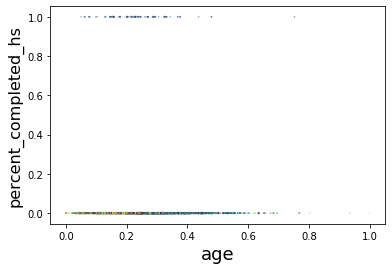

In [880]:
area = np.pi * ( X[:, 1])**2  
plt.scatter(X[:, 0], X[:, 3], s=area, c=labels.astype(np.float), alpha=0.5)
plt.xlabel('age', fontsize=18)
plt.ylabel('percent_completed_hs', fontsize=16)

plt.show()

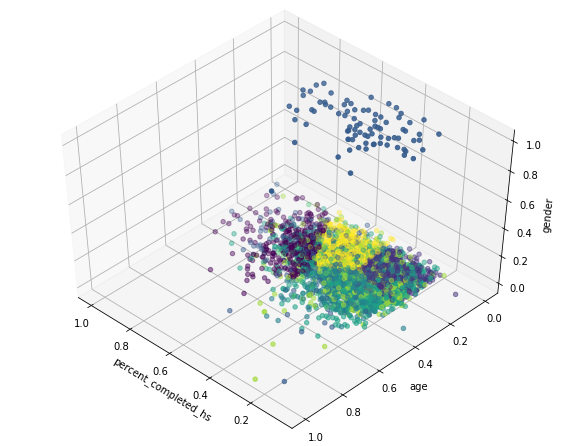

In [881]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('percent_completed_hs')
ax.set_ylabel('age')
ax.set_zlabel('gender')

ax.scatter(X[:, 1], X[:, 0], X[:, 3], c= labels.astype(np.float))

In [882]:
from sklearn.metrics import silhouette_score
silhouette_score(X, k_means.labels_)

0.7733469407861898

## The score rating for the number of clusters was best when k = 8

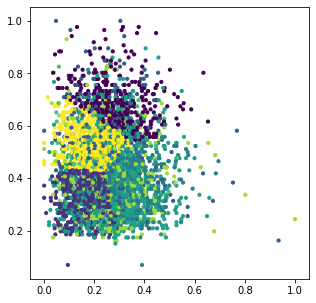

In [892]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

fig = plt.figure(figsize=(5,5))

centers, labels = find_clusters(X, 8)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=10, cmap='viridis');

## The scatter plot above shows the clusters but they overlap in most cases.

In [884]:
df.groupby('Clus_km').mean()

,percent_completed_hs,poverty_rate,age,gender,Asian,Black,Hispanic,None,Other,White
Clus_km,,,,,,,,,,
0,0.842495,0.280831,0.375392,1.000000,0.0,1.000000,0.0,0.0,0.000000,0.0
1,0.860813,0.242530,0.462973,1.000000,0.0,0.000000,0.0,0.0,0.000000,1.0
2,0.803777,0.256963,0.391233,0.973333,0.0,0.000000,1.0,0.0,0.000000,0.0
3,0.844979,0.249322,0.499965,1.000000,0.0,0.000000,0.0,0.0,0.109756,0.0
4,0.854000,0.243571,0.455032,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.0
5,0.867174,0.269254,0.364678,0.942029,0.0,0.000000,0.0,1.0,0.000000,0.0
6,0.845880,0.234987,0.428692,0.951807,1.0,0.000000,0.0,0.0,0.000000,0.0
7,0.843302,0.260718,0.412242,0.000000,0.0,0.811321,0.0,0.0,0.056604,0.0


# Cluster Center Observations

### In all clusters, completed high school education hovers around 85%, poverty rates hover around 25%, age would be considered 'middle-aged', and almost all gender is male.

### Clusters with the lowest levels of education are hispanic and black.

# Overall Report Analysis:

### 1. African Americans are killed more than any other race in the United States by the police. African American violent crimes account for 45% of all crime but African Americans account for only 13% of the population.  Compared with other groups this is disproportionate.

### 2. Individuals who are killed by the police tend to be male, middle-aged.  They also tend to come from areas with increased povery levels and less education.

### 3. African American shootings by police tend to happen in densely populated areas, White tend to happened all over the United States, and Hispanic deaths tend occur on the west coast.